In [1]:
import boto3
import awswrangler as wr
import pandas as pd
from tqdm import tqdm
accessKeys = pd.read_csv("../../../quant-bears_accessKeys.csv")
session = boto3.Session(
	aws_access_key_id=accessKeys.loc[0, "Access key ID"],
	aws_secret_access_key=accessKeys.loc[0, "Secret access key"]
)

s3_collection_path = "s3://quant-bears-data-collection/raw-data/"
s3_price_collection_path = "s3://quant-bears-data-collection/raw-resolved-price/"

In [2]:
data_sources = ["seekingAlpha.seekingAlphaBulkMetrics", "gurufocus"]
sources_dict = dict((source, wr.s3.list_objects(s3_collection_path + source + "/", boto3_session=session)) for source in data_sources)
df_dict = {}

after_date = "2023-10-01"
for source in data_sources:
	dfs = []
	print(source)
	for path in tqdm(sources_dict[source]):
		date = path.split("/")[-1].split(".")[0]
		if date < after_date:
			continue
		new_df = wr.s3.read_parquet(path, boto3_session=session)
		new_df["date"] = date
		dfs.append(new_df)

	df_dict[source] = pd.concat(dfs, axis = 0)
joined_df = pd.concat([df.set_index(["date", "ticker"]) for df in df_dict.values()], axis = 1)
joined_df.shape

seekingAlpha.seekingAlphaBulkMetrics


  0%|          | 0/47 [00:00<?, ?it/s]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ipykernel_87214/3729858734.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["date"] = date
  6%|▋         | 3/47 [00:00<00:07,  5.83it/s]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ipykernel_87214/3729858734.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["date"] = date
  9%|▊         | 4/47 [00:01<00:12,  3.47it/s]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ipykernel_87214/3729858734.py:14: PerformanceWarning:

gurufocus


100%|██████████| 47/47 [00:27<00:00,  1.74it/s]


(71439, 339)

In [3]:
step1_df = joined_df[~joined_df["primary_price"].isna()]
step1_df.shape

(71423, 339)

In [4]:
float_df = step1_df.select_dtypes([int, float])

In [5]:
nan_pct = float_df.isna().sum() / float_df.shape[0]
nan_pct.sort_values(ascending = False)

peg_gaap_avg_5y                 0.992915
Price-to-FFO                    0.937163
cf_payout_avg_5y                0.934307
impliedmarketcap                0.929533
Price-to-Net-Cash               0.883945
                                  ...   
sma_10d                         0.000000
sma_200d                        0.000000
sma_50d                         0.000000
tot_analysts_recommendations    0.000000
last_price_vs_sma_100d          0.000000
Length: 337, dtype: float64

In [6]:
(nan_pct > 0.0).sum()

322

In [7]:
nan_pct.describe()

count    337.000000
mean       0.230532
std        0.222348
min        0.000000
25%        0.035353
50%        0.149000
75%        0.416084
max        0.992915
dtype: float64

In [8]:
nan_pct[abs(nan_pct - 0.153334) < 0.01]

assets_turnover_avg_5y              0.146115
ebitda_yoy_avg_5y                   0.162763
gross_margin_avg_5y                 0.145919
momentum_12m_avg_5y                 0.146185
oper_income_fy1_market_cap          0.149616
operating_income_ebit_yoy_avg_5y    0.156924
return_on_total_capital_avg_5y      0.156938
roe_yoy_avg_5y                      0.155440
working_cap_change_avg_5y           0.156910
Days_Sales_Outstanding              0.144575
Days_Payable                        0.149000
dtype: float64

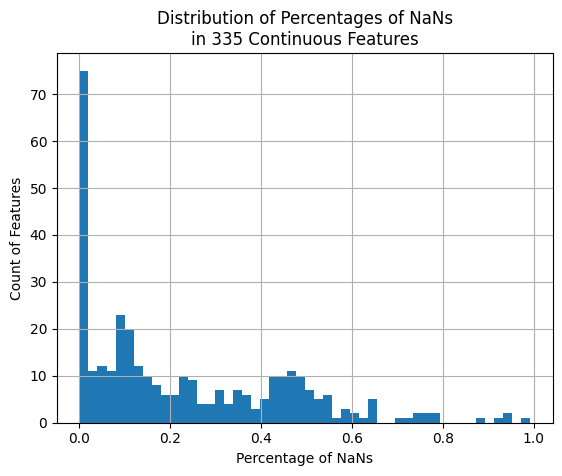

In [12]:
import matplotlib.pyplot as plt
nan_pct.hist(bins=50)
plt.title("Distribution of Percentages of NaNs\nin 335 Continuous Features")
plt.xlabel("Percentage of NaNs")
plt.ylabel("Count of Features")
plt.savefig("nan_pct_distribution.png", dpi = 300)

In [22]:
nan_pct[nan_pct == 0.0].shape

(19,)

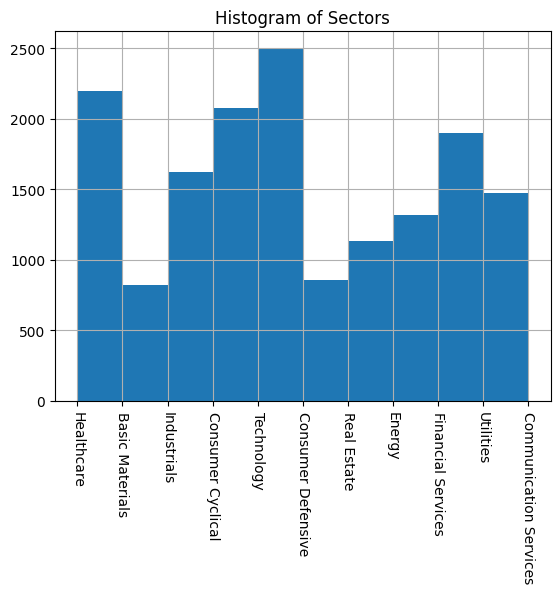

In [8]:
import matplotlib.pyplot as plt
step1_df["sector"].hist()
plt.title("Histogram of Sectors")
plt.xticks(rotation = -90)
pass

In [15]:
float_df.isna().sum().sum() / (float_df.shape[0] * float_df.shape[1])

0.23053196962419448